In [65]:
import numpy as np
import pandas as pd
import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split, TensorDataset

In [83]:
folder_path = '../../ADFA-LD-Dataset/ADFA-LD/Training_Data_Master' 
data = []
sequence_length = 10
unique = []

# Process each file
for filename in os.listdir(folder_path):
    file_path = os.path.join(folder_path, filename)
    if os.path.isfile(file_path):
        with open(file_path, 'r') as file:
            content = file.read().split()
            content = [int(s) for s in content]
            combined_batches = [content[i:i + sequence_length] for i in range(0, len(content))]
            combined_batches = [lst for lst in combined_batches if len(lst) == sequence_length]
            data.extend(combined_batches)
            unique.extend(content)

unique_syscalls = set(unique)
num_unique_syscalls = len(unique_syscalls)


In [109]:
# Create a mapping from system call number to a unique index
mapping = {sys_call: i for i, sys_call in enumerate(unique_syscalls)}

# Apply the mapping to each system call in each sequence
mapped_data = [[mapping[sys_call] for sys_call in sequence] for sequence in data]


# Now proceed with creating tensors and DataLoader
tensors = [torch.tensor(x) for x in mapped_data]
tensor = torch.stack(tensors)
dataset = TensorDataset(tensor)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

[320, 322, 331, 332]
[[4, 9, 27, 19, 84, 19, 3, 88, 84, 4], [9, 27, 19, 84, 19, 3, 88, 84, 4, 19], [27, 19, 84, 19, 3, 88, 84, 4, 19, 3], [19, 84, 19, 3, 88, 84, 4, 19, 3, 1], [84, 19, 3, 88, 84, 4, 19, 3, 1, 88], [19, 3, 88, 84, 4, 19, 3, 1, 88, 84], [3, 88, 84, 4, 19, 3, 1, 88, 84, 84], [88, 84, 4, 19, 3, 1, 88, 84, 84, 4], [84, 4, 19, 3, 1, 88, 84, 84, 4, 19], [4, 19, 3, 1, 88, 84, 84, 4, 19, 3]]


In [101]:
class Autoencoder(nn.Module):
    def __init__(self, num_system_calls, embedding_dim, encoding_dim, hidden_dim = 4):
        super(Autoencoder, self).__init__()
        self.embedding_dim = embedding_dim  # Store embedding_dim

        self.embedding = nn.Embedding(num_system_calls, embedding_dim)

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(10 * embedding_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, encoding_dim)
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 10 * embedding_dim)  # Output size matches the total size of embedded input
        )

    def forward(self, x):
        x = self.embedding(x)
        x = x.view(x.size(0), -1)
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        decoded = decoded.view(-1, 10)  # Reshape to [batch_size, sequence_length, embedding_dim]
        return decoded


In [102]:
from math import ceil

embedding_dim = ceil(num_unique_syscalls**(0.25))
encoding_dim = round((embedding_dim * sequence_length) /3)
autoencoder = Autoencoder(num_system_calls = num_unique_syscalls, embedding_dim = embedding_dim, encoding_dim = encoding_dim)


In [103]:
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=0.01)
criterion = nn.MSELoss()
loss_history = []

num_epochs = 20
for epoch in range(num_epochs):
    for batch in dataloader:
        inputs = batch[0]
        embedded_inputs = autoencoder.embedding(inputs)  # Embed the inputs
        embedded_inputs = embedded_inputs.view(inputs.size(0), -1)  # Flatten the embedded inputs

        outputs = autoencoder(inputs)
        outputs = outputs.view(inputs.size(0), -1)  # Flatten the outputs

        loss = criterion(outputs, embedded_inputs)  # Compute loss between embedded input and output
        loss_history.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.8f}')


Epoch [1/20], Loss: 0.00000017
Epoch [2/20], Loss: 0.00000373
Epoch [3/20], Loss: 0.00002226
Epoch [4/20], Loss: 0.00000267
Epoch [5/20], Loss: 0.00000369
Epoch [6/20], Loss: 0.00000145
Epoch [7/20], Loss: 0.00000450
Epoch [8/20], Loss: 0.00000446
Epoch [9/20], Loss: 0.00000243
Epoch [10/20], Loss: 0.00000203
Epoch [11/20], Loss: 0.00000217
Epoch [12/20], Loss: 0.00000302
Epoch [13/20], Loss: 0.00000522
Epoch [14/20], Loss: 0.00000124
Epoch [15/20], Loss: 0.00000353
Epoch [16/20], Loss: 0.00000434
Epoch [17/20], Loss: 0.00000723
Epoch [18/20], Loss: 0.00000061
Epoch [19/20], Loss: 0.00000624
Epoch [20/20], Loss: 0.00001366


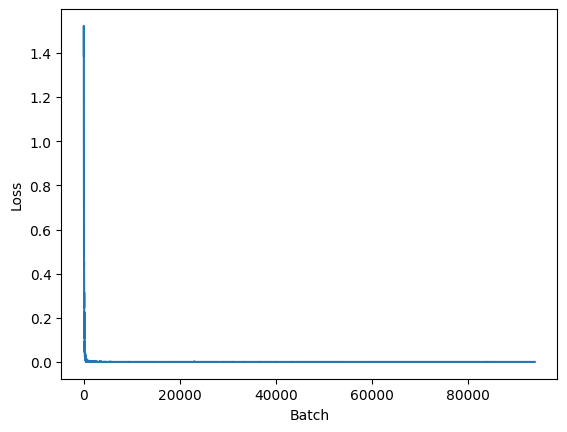

In [104]:
# plot loss history over epochs
import matplotlib.pyplot as plt
plt.plot(loss_history)
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.show()
